In [1]:
import pandas as pd
import numpy as np
import os
%load_ext autoreload
%autoreload 2 

In [2]:
from utils import preprocess_utility_matrix as um
from method2 import build_iterative_model as im

In [3]:
movies_df = pd.DataFrame({'M1': [2, None, 3, None, 1, 5],
                          'M2': [None, 1, None, 5, 1, None],
                          'M3': [5, 4, 1, 1, 4, None],
                          'M4': [5, 4, None, None, None, 1]},
                         index=[f'U{i+1}' for i in range(6)])
movies_df

,M1,M2,M3,M4
U1,2.0,NaN,5.0,5.0
U2,NaN,1.0,4.0,4.0
U3,3.0,NaN,1.0,NaN
U4,NaN,5.0,1.0,NaN
U5,1.0,1.0,4.0,NaN
U6,5.0,NaN,NaN,1.0


# Preprocess Utility Matrix

In [4]:
U_df = movies_df.copy()
U_df

,M1,M2,M3,M4
U1,2.0,NaN,5.0,5.0
U2,NaN,1.0,4.0,4.0
U3,3.0,NaN,1.0,NaN
U4,NaN,5.0,1.0,NaN
U5,1.0,1.0,4.0,NaN
U6,5.0,NaN,NaN,1.0


In [5]:
U_df_mc = um.mean_center_utilmat(U_df, axis=1, fillna=True, fill_val=0)
U_df_mc

,M1,M2,M3,M4
U1,-2.0,0.0,1.0,1.0
U2,0.0,-2.0,1.0,1.0
U3,1.0,0.0,-1.0,0.0
U4,0.0,2.0,-2.0,0.0
U5,-1.0,-1.0,2.0,0.0
U6,2.0,0.0,0.0,-2.0


In [6]:
known_index, missing_index = um.known_missing_split_U(
    U_df_mc, split_axis=1, missing_val_filled=True, )

In [7]:
known_index, missing_index

({'M1': Index(['U1', 'U3', 'U5', 'U6'], dtype='object'),
  'M2': Index(['U2', 'U4', 'U5'], dtype='object'),
  'M3': Index(['U1', 'U2', 'U3', 'U4', 'U5'], dtype='object'),
  'M4': Index(['U1', 'U2', 'U6'], dtype='object')},
 {'M1': Index(['U2', 'U4'], dtype='object'),
  'M2': Index(['U1', 'U3', 'U6'], dtype='object'),
  'M3': Index(['U6'], dtype='object'),
  'M4': Index(['U3', 'U4', 'U5'], dtype='object')})

## Build Models

In [8]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
mlp1 = MLPRegressor(hidden_layer_sizes=(100, 100))

In [9]:
U = U_df_mc.copy()
model_object = mlp1

models_item = im.initialize_models_itemwise(model_object, U, suffix='')
models_item

{'M1': MLPRegressor(hidden_layer_sizes=(100, 100)),
 'M2': MLPRegressor(hidden_layer_sizes=(100, 100)),
 'M3': MLPRegressor(hidden_layer_sizes=(100, 100)),
 'M4': MLPRegressor(hidden_layer_sizes=(100, 100))}

In [10]:
U_imputed, metrics, models = im.train_model_itemwise(U, mlp1, return_models=True)

In [11]:
metrics

[2.6606449824444933, 0.33328486734034646, 0.04097416915601879]

In [12]:
movies_df

,M1,M2,M3,M4
U1,2.0,NaN,5.0,5.0
U2,NaN,1.0,4.0,4.0
U3,3.0,NaN,1.0,NaN
U4,NaN,5.0,1.0,NaN
U5,1.0,1.0,4.0,NaN
U6,5.0,NaN,NaN,1.0


In [13]:
U_imputed.add(movies_df.mean(axis=1), axis=0)

,M1,M2,M3,M4
U1,2.000000,1.732974,5.00000,5.000000
U2,1.325105,1.000000,4.00000,4.000000
U3,3.000000,2.742979,1.00000,0.535444
U4,5.634996,5.000000,1.00000,0.011292
U5,1.000000,1.000000,4.00000,2.490220
U6,5.000000,4.504799,1.46964,1.000000


In [14]:
U_imputed.add(movies_df.mean(axis=1), axis=0).round()

,M1,M2,M3,M4
U1,2.0,2.0,5.0,5.0
U2,1.0,1.0,4.0,4.0
U3,3.0,3.0,1.0,1.0
U4,6.0,5.0,1.0,0.0
U5,1.0,1.0,4.0,2.0
U6,5.0,5.0,1.0,1.0


In [15]:
models

{'M1': MLPRegressor(hidden_layer_sizes=(100, 100)),
 'M2': MLPRegressor(hidden_layer_sizes=(100, 100)),
 'M3': MLPRegressor(hidden_layer_sizes=(100, 100)),
 'M4': MLPRegressor(hidden_layer_sizes=(100, 100))}

## Cluster based item-wise iterative model

In [16]:
np.random.seed(12345678)

In [17]:
nc = 10
nr = 100
sample_util_mat = pd.DataFrame(np.random.uniform(1, 5, (nr, nc)), columns=np.arange(1, nc+1),
                               index=np.arange(1, nr+1)).round(2)
sample_util_mat.head()

,1,2,3,4,5,6,7,8,9,10
1,1.98,3.39,2.44,2.52,1.10,1.95,2.55,3.72,4.36,4.04
2,1.89,1.25,4.12,3.89,1.78,3.05,1.28,2.58,4.93,2.22
3,4.13,3.94,4.35,1.49,4.47,3.24,4.35,3.96,4.14,3.73
4,4.66,1.89,3.29,3.52,1.05,2.05,3.92,4.16,2.30,2.11
5,1.49,2.64,4.81,1.96,1.04,1.08,3.64,3.73,3.80,3.80


In [18]:
Uc = sample_util_mat.copy()
Uc_arr = Uc.values
Uc_arr.shape

(100, 10)

In [19]:
def nan_mask(U, p=0.2):
    mask = np.ones(np.shape(U))
    random_index = np.random.choice(U.size, size=int(U.size*p), replace=False)
    np.ravel(mask)[random_index] = np.nan
    return U*mask

In [20]:
def gen_missing_ratings(U_df, p=0.2, n_masks=10):
    cols = U_df.columns
    idx = U_df.index
    U_arr = U_df.values
    masked_um = []
    for n in range(n_masks):
        masked_um.append(pd.DataFrame(nan_mask(U_arr, p=p),
                                      columns=cols,
                                      index=idx))
    return masked_um

In [21]:
def train_model_itemwise_cluster(Uc_df, n_synth_data=100, p=0.3):
    synth_data = gen_missing_ratings(Uc_df, p=p, n_masks=n_synth_data)
    um_output = []
    for n in range(n_synth_data):
#         print(n)
        U_df = synth_data[n]
        U_df_mc = um.mean_center_utilmat(U_df, axis=1, fillna=True, fill_val=0)
        U_imputed, metrics, models = im.train_model_itemwise(
            U_df_mc, mlp1, return_models=True)
        um_output.append(U_imputed)
    um_output = pd.concat(um_output)
    return um_output.groupby(um_output.index).mean()

In [22]:
%%time
Uc_df_output = train_model_itemwise_cluster(Uc, n_synth_data=20, p=0.5)

CPU times: user 2min 28s, sys: 17.8 s, total: 2min 46s
Wall time: 42.2 s


In [23]:
Uc_df_output

,1,2,3,4,5,6,7,8,9,10
1,-0.564879,0.444075,0.099880,-0.032477,-0.814170,-0.549418,-0.264714,0.386276,0.732103,0.825674
2,-0.276745,-0.770119,0.668810,0.628158,-0.515408,0.117801,-0.222044,-0.076345,1.029355,0.032829
3,0.019099,0.119873,0.324212,-0.759468,0.357400,-0.281754,0.284988,-0.060430,0.119311,-0.119509
4,0.831349,-0.284369,0.084006,0.538948,-1.174975,-0.667267,0.395567,0.950257,-0.339734,-0.274686
5,-0.584715,0.132368,1.358636,-0.784919,-0.818388,-0.769652,0.439653,0.186520,0.627836,0.711734
...,...,...,...,...,...,...,...,...,...,...
96,-0.628261,0.974417,0.038752,-0.683515,0.384567,-0.633225,-0.237920,-0.723705,0.788922,0.547416
97,-0.178800,-0.247348,-0.576279,-0.117154,0.518521,-0.190281,0.795683,0.168475,-0.122528,-0.120398
98,-0.557627,0.543934,0.895406,-0.866473,0.174473,-0.028557,-0.603036,-0.618714,0.125142,0.868991
99,-0.108538,-0.041217,0.128019,0.298424,-0.437466,-0.358596,-0.386778,-0.312278,0.672422,0.537355


In [24]:
import matplotlib.pyplot as plt

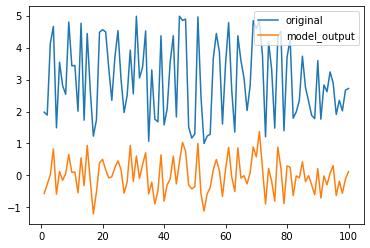

In [25]:
item=1
fig, ax = plt.subplots(1)
Uc[item].plot(label='original')
Uc_df_output[item].plot(label='model_output')
plt.legend()